In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:

# Load data
crypto_data = pd.read_csv('crypto-markets.csv')
currency_data = pd.read_csv('all_currencies.csv')

In [3]:
parsedates = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#Reading CSV file
df = pd.read_csv('/content/crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=parsedates)
df.head()


<ipython-input-3-8b3759a068a0>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parsedates = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [4]:
bc=df[df['symbol']=='BTC']
bc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True)
bc.head()

<ipython-input-4-ff4f9751c8f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True)


,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


In [5]:
bc_mth = bc.resample('M').mean()

**Stationarity check**

In [6]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject null hypothesis, data is stationary")
    else:
        print("Fail to reject null hypothesis, data is non-stationary")

check_stationarity(bc_mth.close)


ADF Statistic: 2.11313571600006
p-value: 0.998803073857534
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597
Fail to reject null hypothesis, data is non-stationary


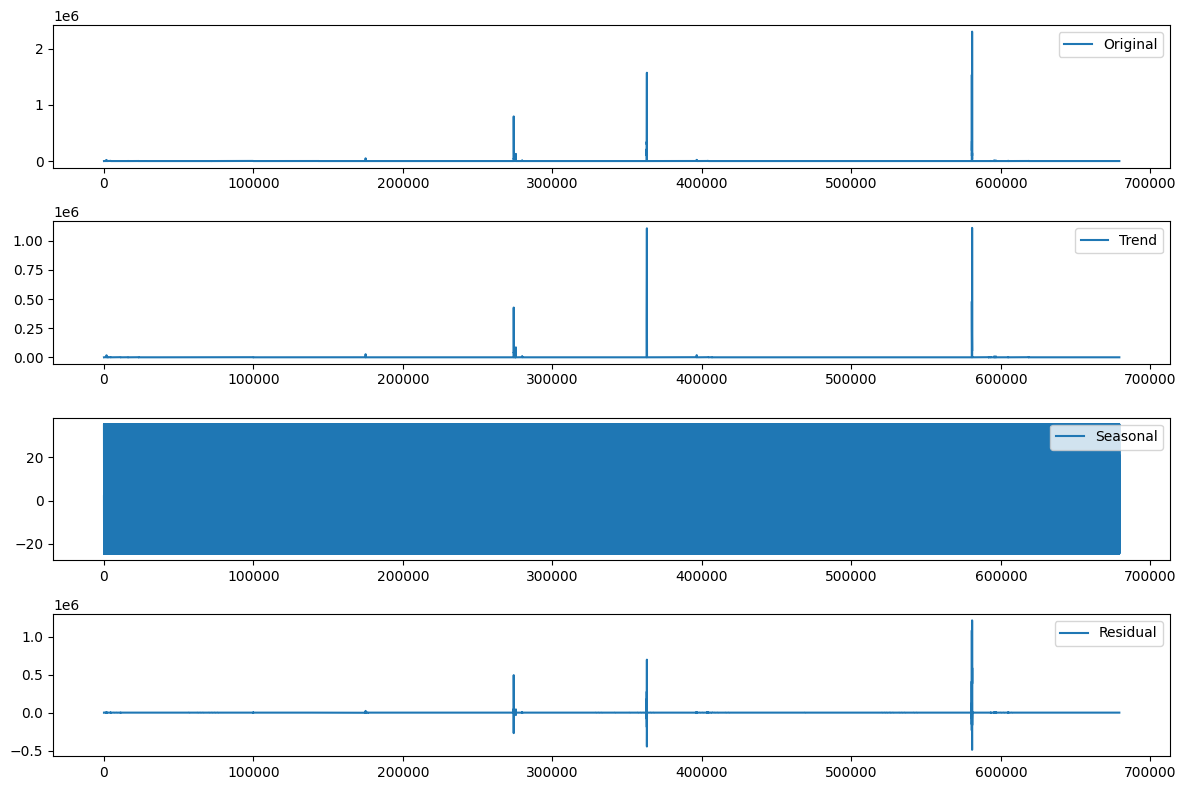

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv('/content/crypto-markets.csv')

data.dropna(inplace=True)

decomposition = seasonal_decompose(data['close'] , model='additive', period=12)  # Adjust the period as needed


plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data.index, data['close'], label='Original')  # Assuming 'close' is the column containing the close prices
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend.index, decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid.index, decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



**Box-Cox Transformation**

In [11]:
print(data.dtypes)


slug            object
symbol          object
name            object
date            object
ranknow          int64
open           float64
high           float64
low            float64
close          float64
volume           int64
market           int64
close_ratio    float64
spread         float64
dtype: object


In [13]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns

from datetime import datetime, timedelta

#importing libraries necessary for model creation
from statsmodels.tsa.arima_model import ARIMA                 #library for ARIMA model implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX        #library for SARIMAX model implementation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #library imported for plotting ACG and PACF graphs
from statsmodels.tsa.stattools import adfuller                #library to compute with ADFuller test

#importing library for seasonal decomposition implementation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')


In [15]:
import pandas as pd
from scipy.stats import boxcox
min_value = data['close'].min()

shifted_data = data['close'] - min_value + 1  # Add 1 to avoid zero values

transformed_data, lambda_value = boxcox(shifted_data)

print("Optimal lambda:", lambda_value)


Optimal lambda: -2.431172222617656


In [16]:
import numpy as np
from scipy import stats

min_value = bc_mth['close'].min()

shifted_data = bc_mth['close'] - min_value + 1  # Add 1 to avoid zero values

bc_mth['close_box'], lmbda = stats.boxcox(shifted_data)

print("Augmented Dickey Fuller (ADF) test result: p =", adfuller(bc_mth['close_box'])[1])


Augmented Dickey Fuller (ADF) test result: p = 0.6284283938132221


**Seasonal Differentiation**

In [17]:
bc_mth['box_diff_seasonal_12'] = bc_mth['close_box'] - bc_mth['close_box'].shift(12)

p_value_12 = adfuller(bc_mth['box_diff_seasonal_12'][12:])[1]
print("Augmented Dickey Fuller (ADF) test result for seasonal differentiation with lag 12 months: p =", p_value_12)


Augmented Dickey Fuller (ADF) test result for seasonal differentiation with lag 12 months: p = 0.5620945876007906


In [18]:
bc_mth['box_diff_seasonal_3'] = bc_mth['close_box'] - bc_mth['close_box'].shift(3)

p_value_3 = adfuller(bc_mth['box_diff_seasonal_3'][3:])[1]
print("Augmented Dickey Fuller (ADF) test result for seasonal differentiation with lag 3 months: p =", p_value_3)


Augmented Dickey Fuller (ADF) test result for seasonal differentiation with lag 3 months: p = 0.0005978892044527963


**Regular Differentiation**

Augmented Dickey Fuller (ADF) test result after second order differencing: p = 1.4399214150000754e-07


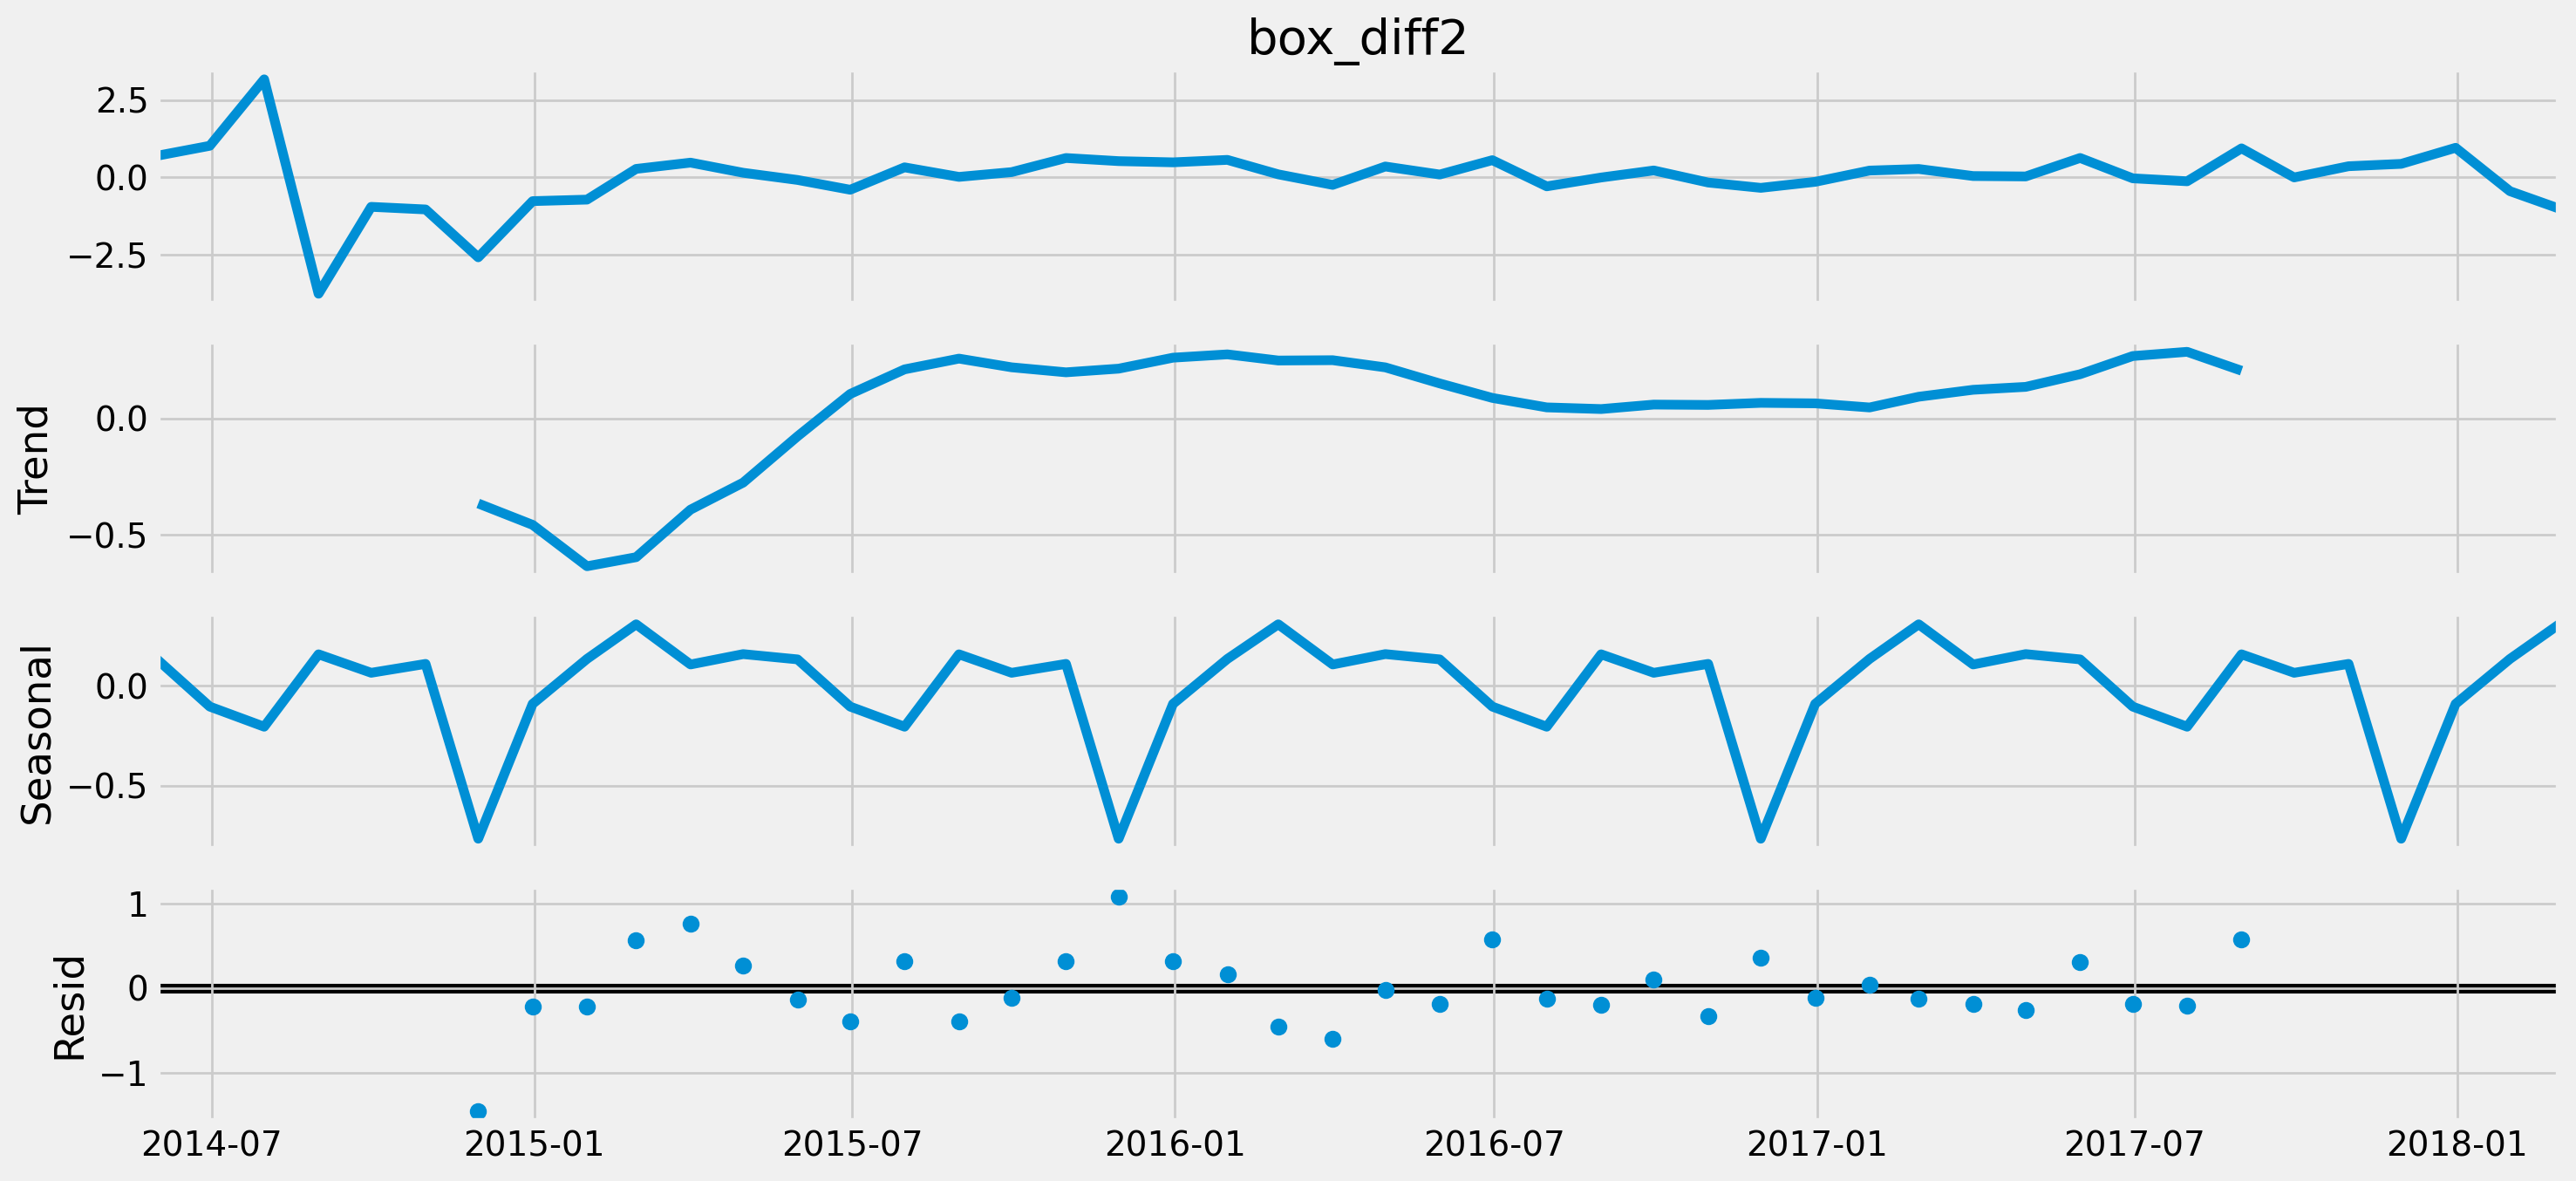

In [19]:
bc_mth['box_diff2'] = bc_mth['box_diff_seasonal_12'] - bc_mth['box_diff_seasonal_12'].shift(1)

seasonal_decompose(bc_mth['box_diff2'][13:]).plot()

p_value_diff2 = adfuller(bc_mth['box_diff2'][13:])[1]
print("Augmented Dickey Fuller (ADF) test result after second order differencing: p =", p_value_diff2)

plt.show()


**AutoCorrelation**

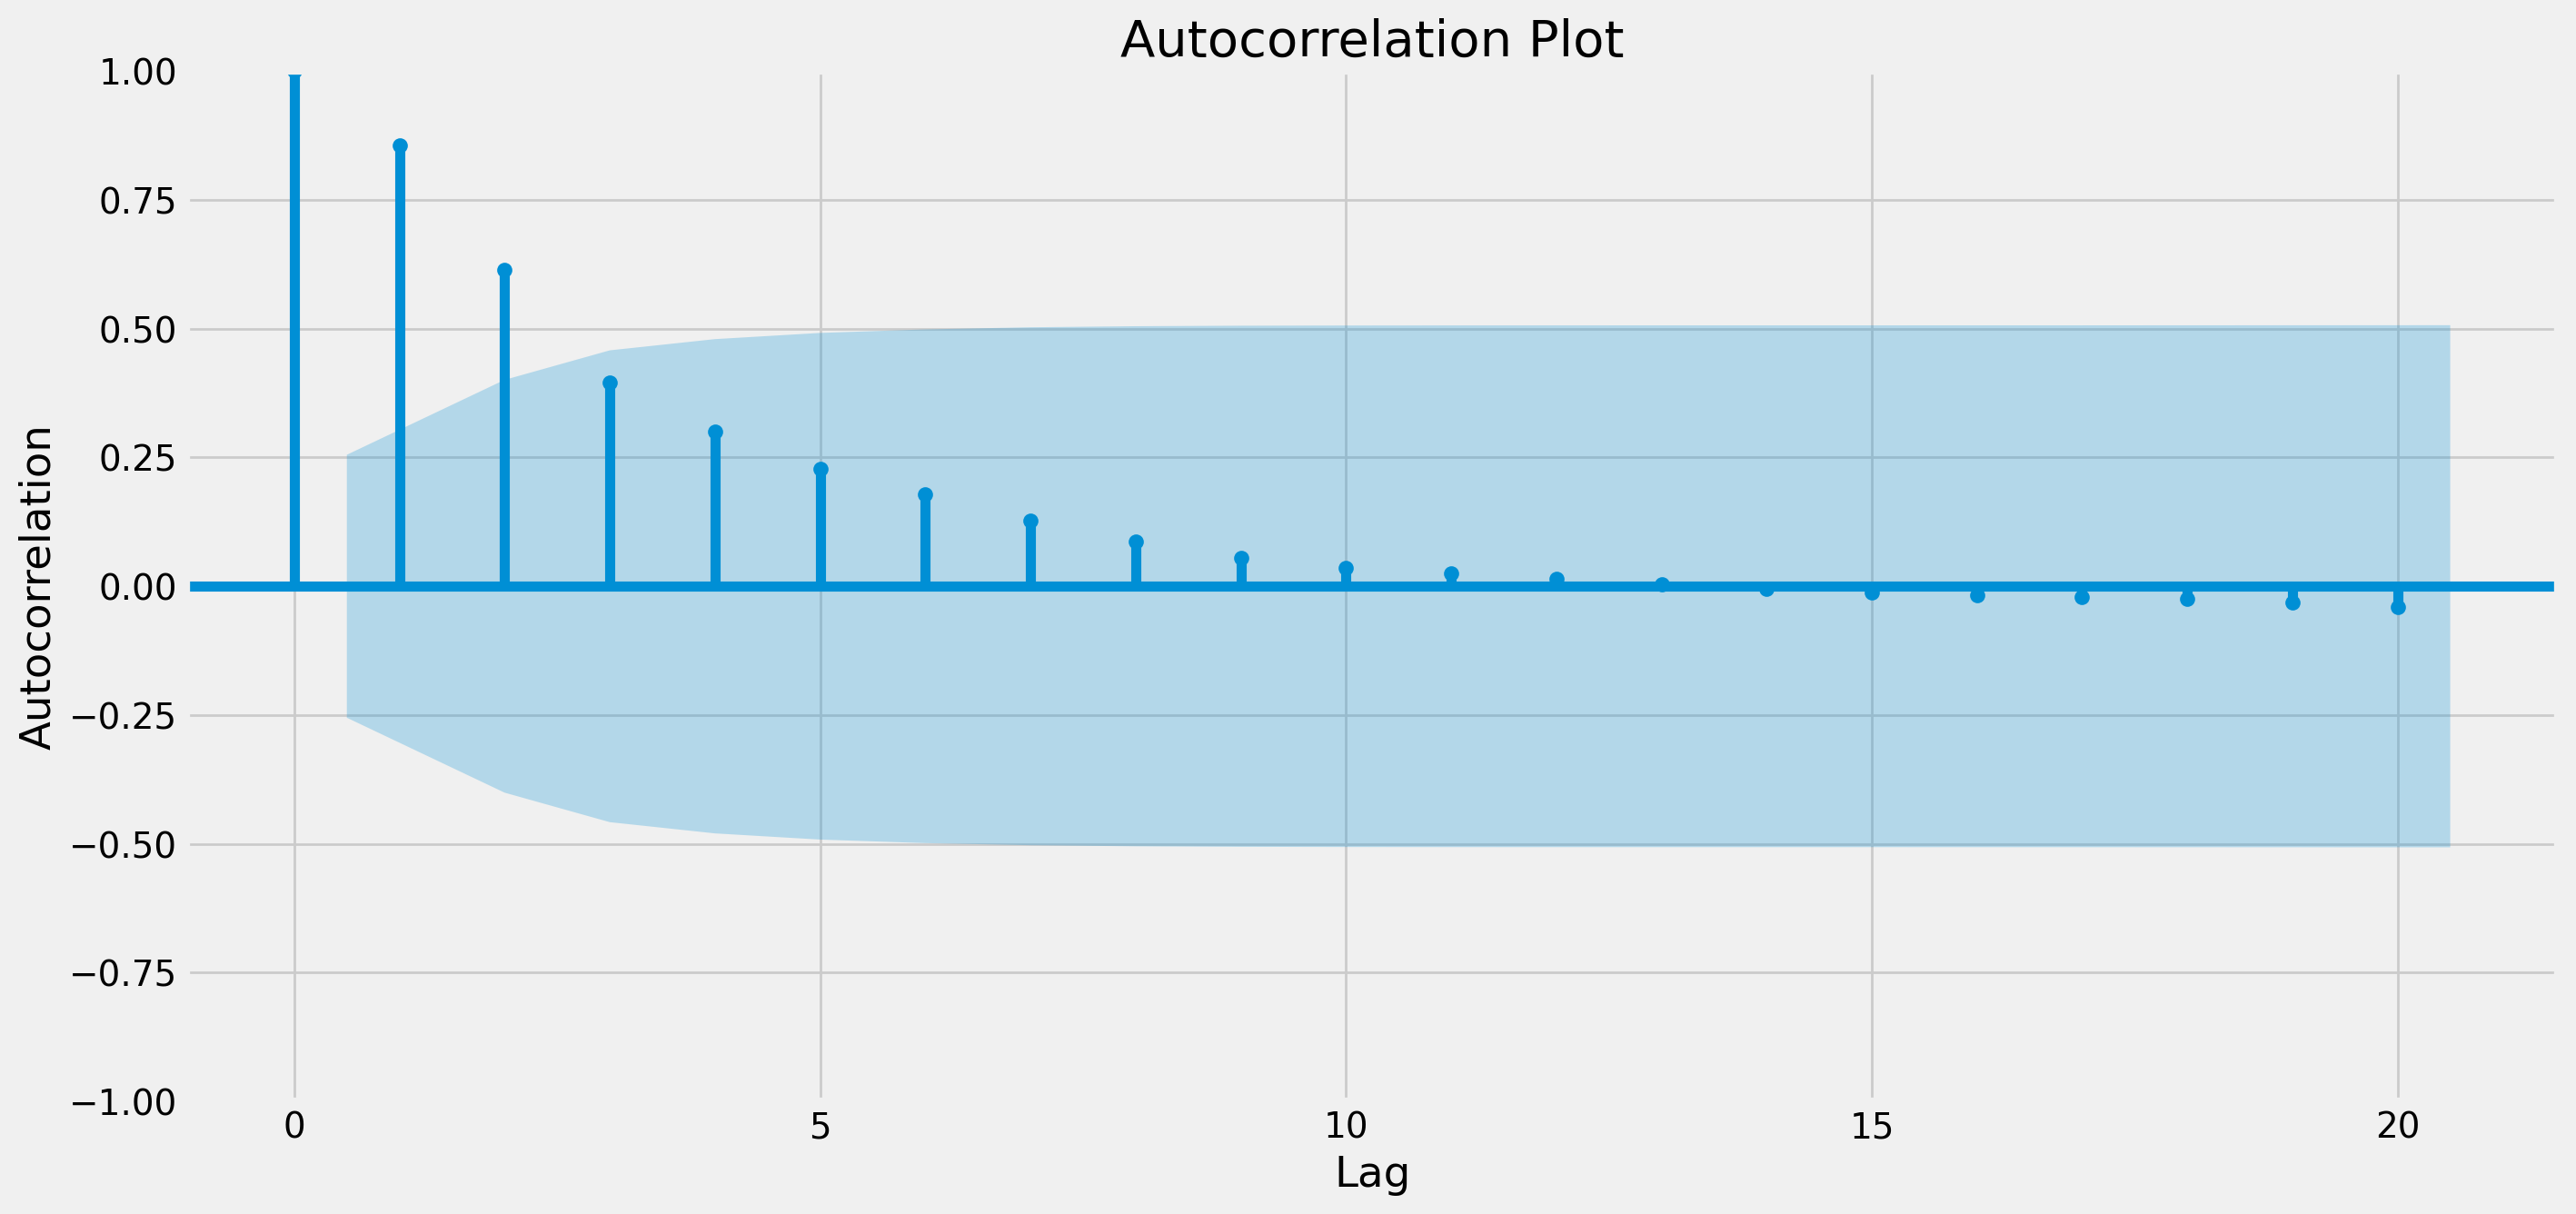

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(bc_mth['close'], lags=20)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


In [21]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns

from datetime import datetime, timedelta

#importing libraries necessary for model creation
from statsmodels.tsa.arima_model import ARIMA                 #library for ARIMA model implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX        #library for SARIMAX model implementation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #library imported for plotting ACG and PACF graphs
from statsmodels.tsa.stattools import adfuller                #library to compute with ADFuller test

#importing library for seasonal decomposition implementation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')


In [22]:
print(bc_mth.columns)


Index(['open', 'high', 'low', 'close', 'close_box', 'box_diff_seasonal_12',
       'box_diff_seasonal_3', 'box_diff2'],
      dtype='object')


In [23]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings

qs = range(0, 3)
ps = range(0, 3)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)

rslt = []
aic_best = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = ARIMA(bc_mth.close, order=(param[0], d, param[1])).fit()
    except ValueError:
        print('Poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_best:
        mdl_best = model
        aic_best = aic
        params_best = param
    rslt.append([param, model.aic])


In [24]:

rslt_table = pd.DataFrame(rslt)
rslt_table.columns = ['parameters', 'aic']
print(rslt_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
8     (2, 2)  986.363359
6     (2, 0)  988.969951
7     (2, 1)  991.056404
2     (0, 2)  991.912794
1     (0, 1)  992.389982


In [25]:
print(mdl_best.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   59
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -488.182
Date:                Thu, 08 Feb 2024   AIC                            986.363
Time:                        12:32:59   BIC                            996.666
Sample:                    04-30-2013   HQIC                           990.376
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6836      0.271     -2.522      0.012      -1.215      -0.152
ar.L2         -0.6722      0.233     -2.884      0.004      -1.129      -0.215
ma.L1          1.2776      0.809      1.580      0.1

In [26]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(bc_mth['close'])
print("Augmented Dickey Fuller (ADF) test result: p={:.6f}".format(adf_result[1]))


Augmented Dickey Fuller (ADF) test result: p=0.998803


Augmented Dickey Fuller(ADF) test result: p=0.998973


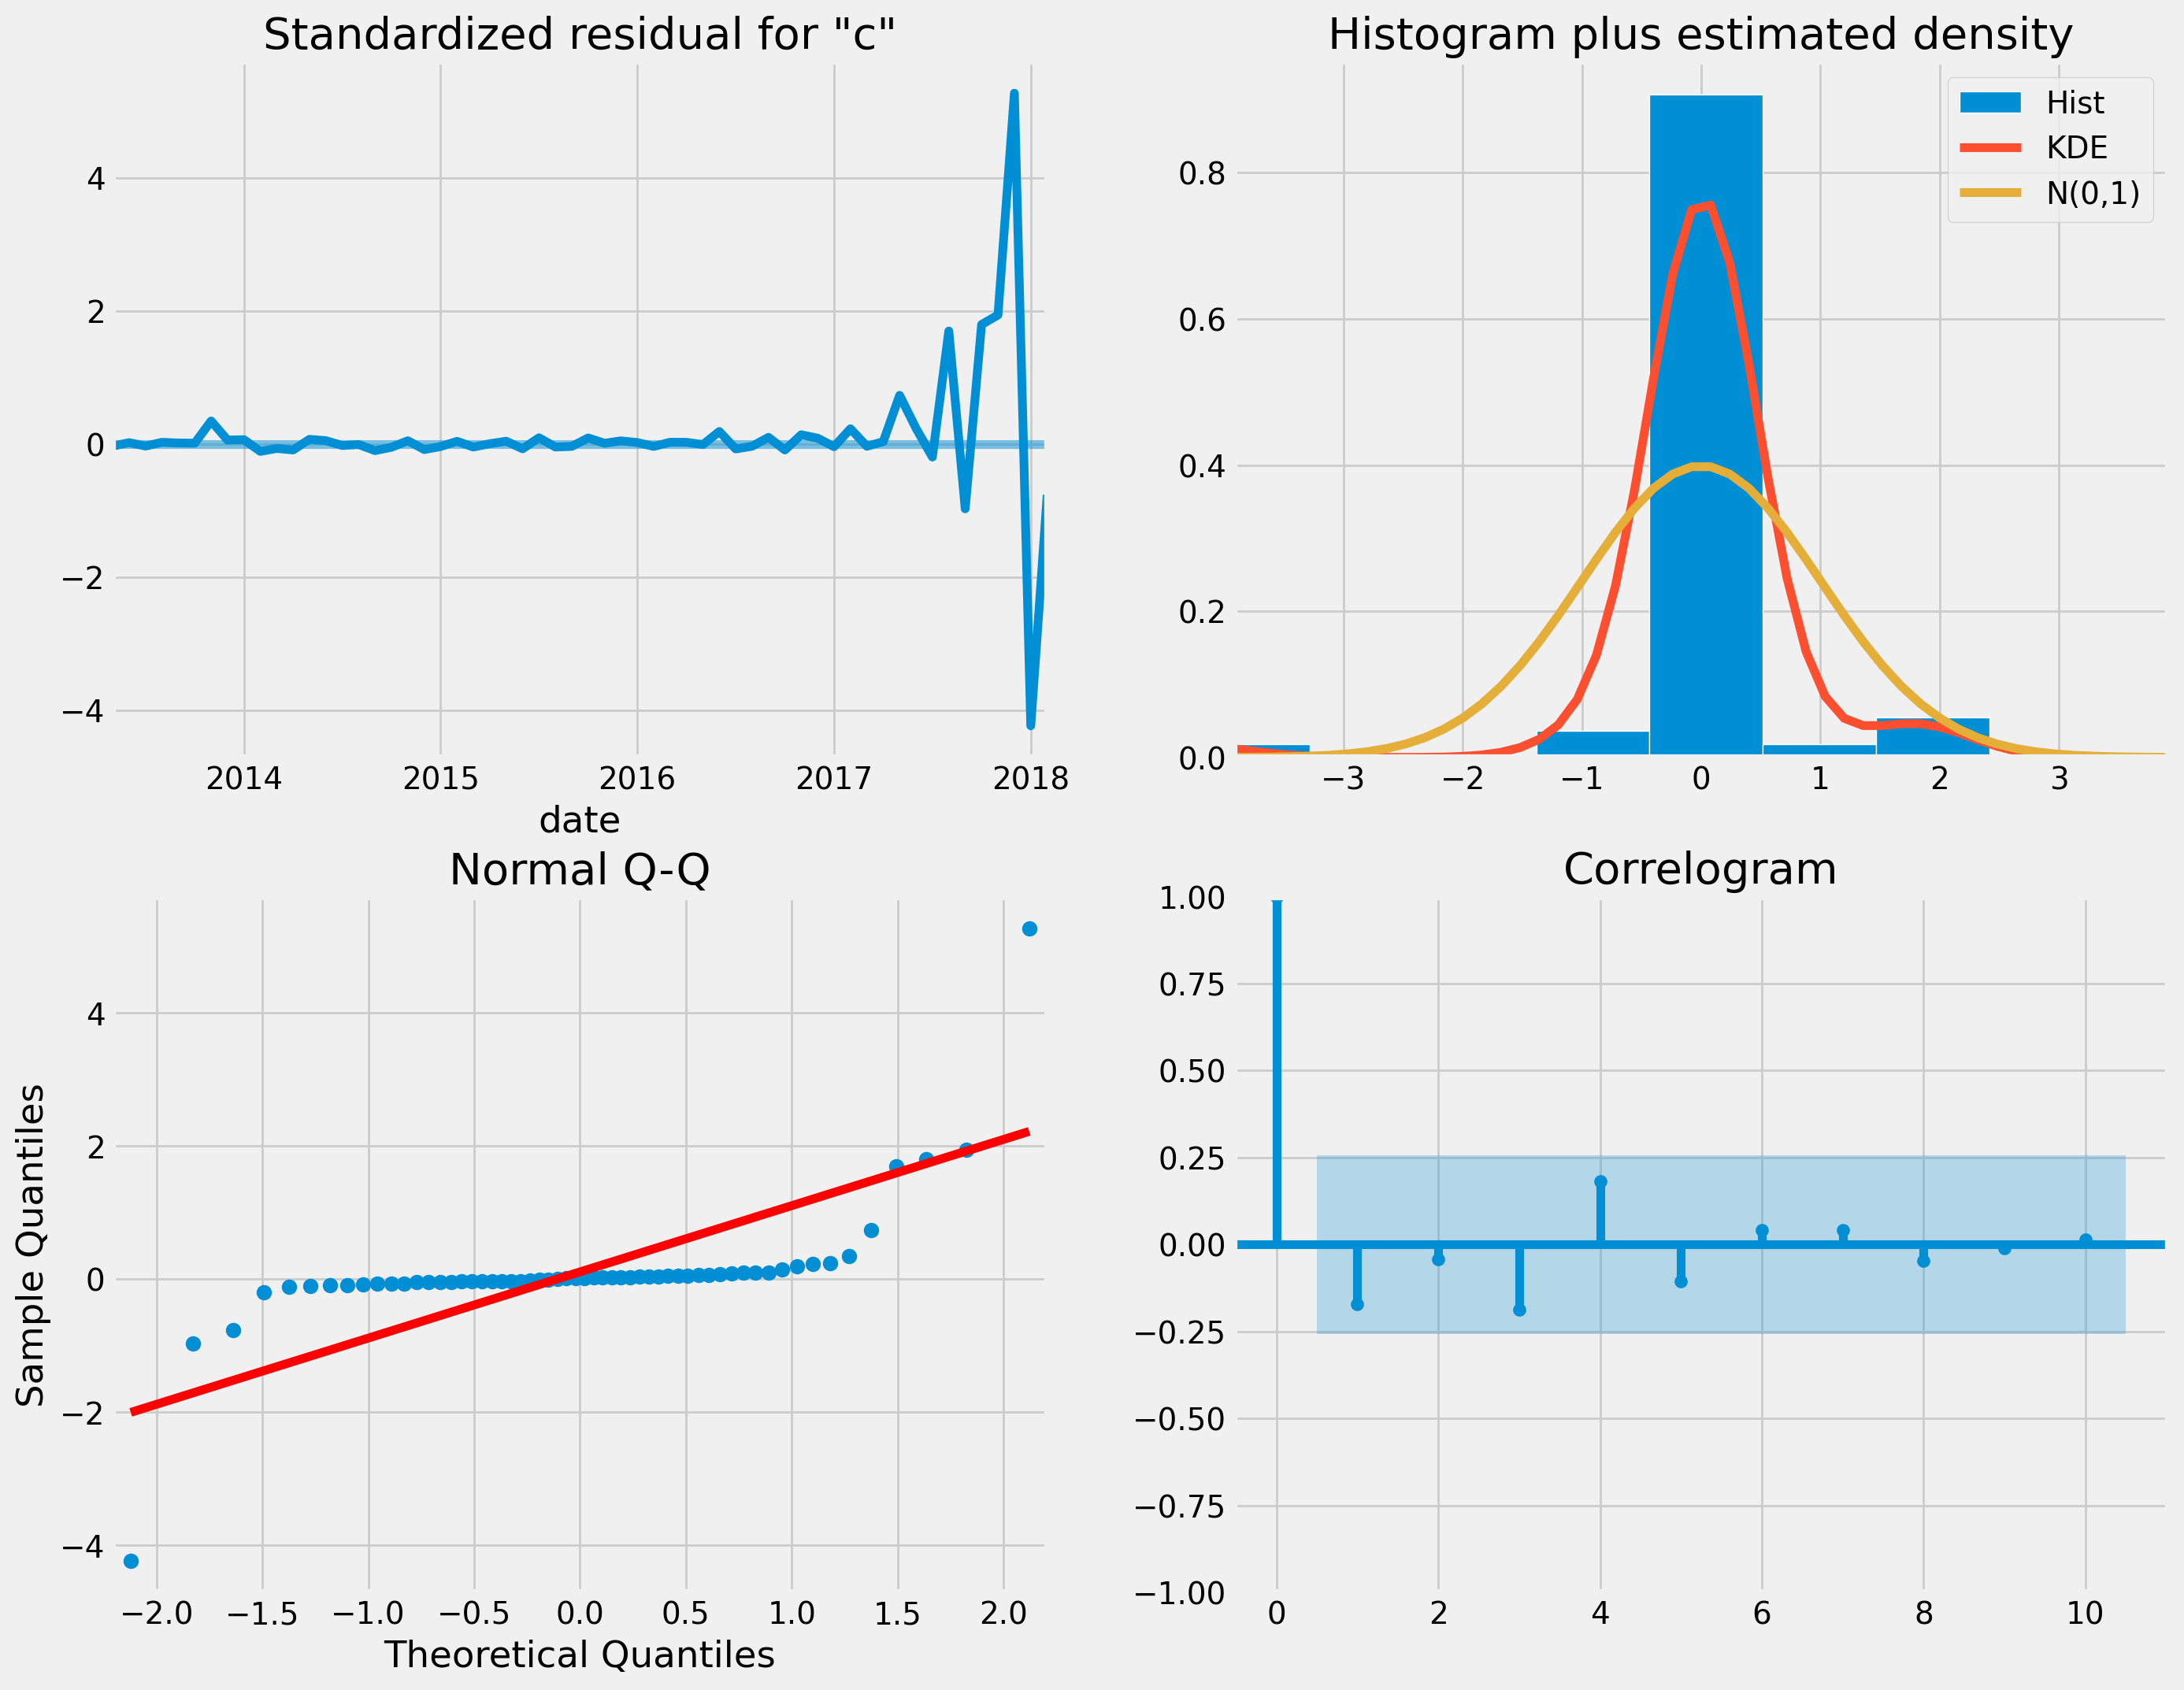

In [27]:

print("Augmented Dickey Fuller(ADF) test result: p=%f" % adfuller(mdl_best.resid[13:])[1])

mdl_best.plot_diagnostics(figsize=(15, 12))
plt.show()


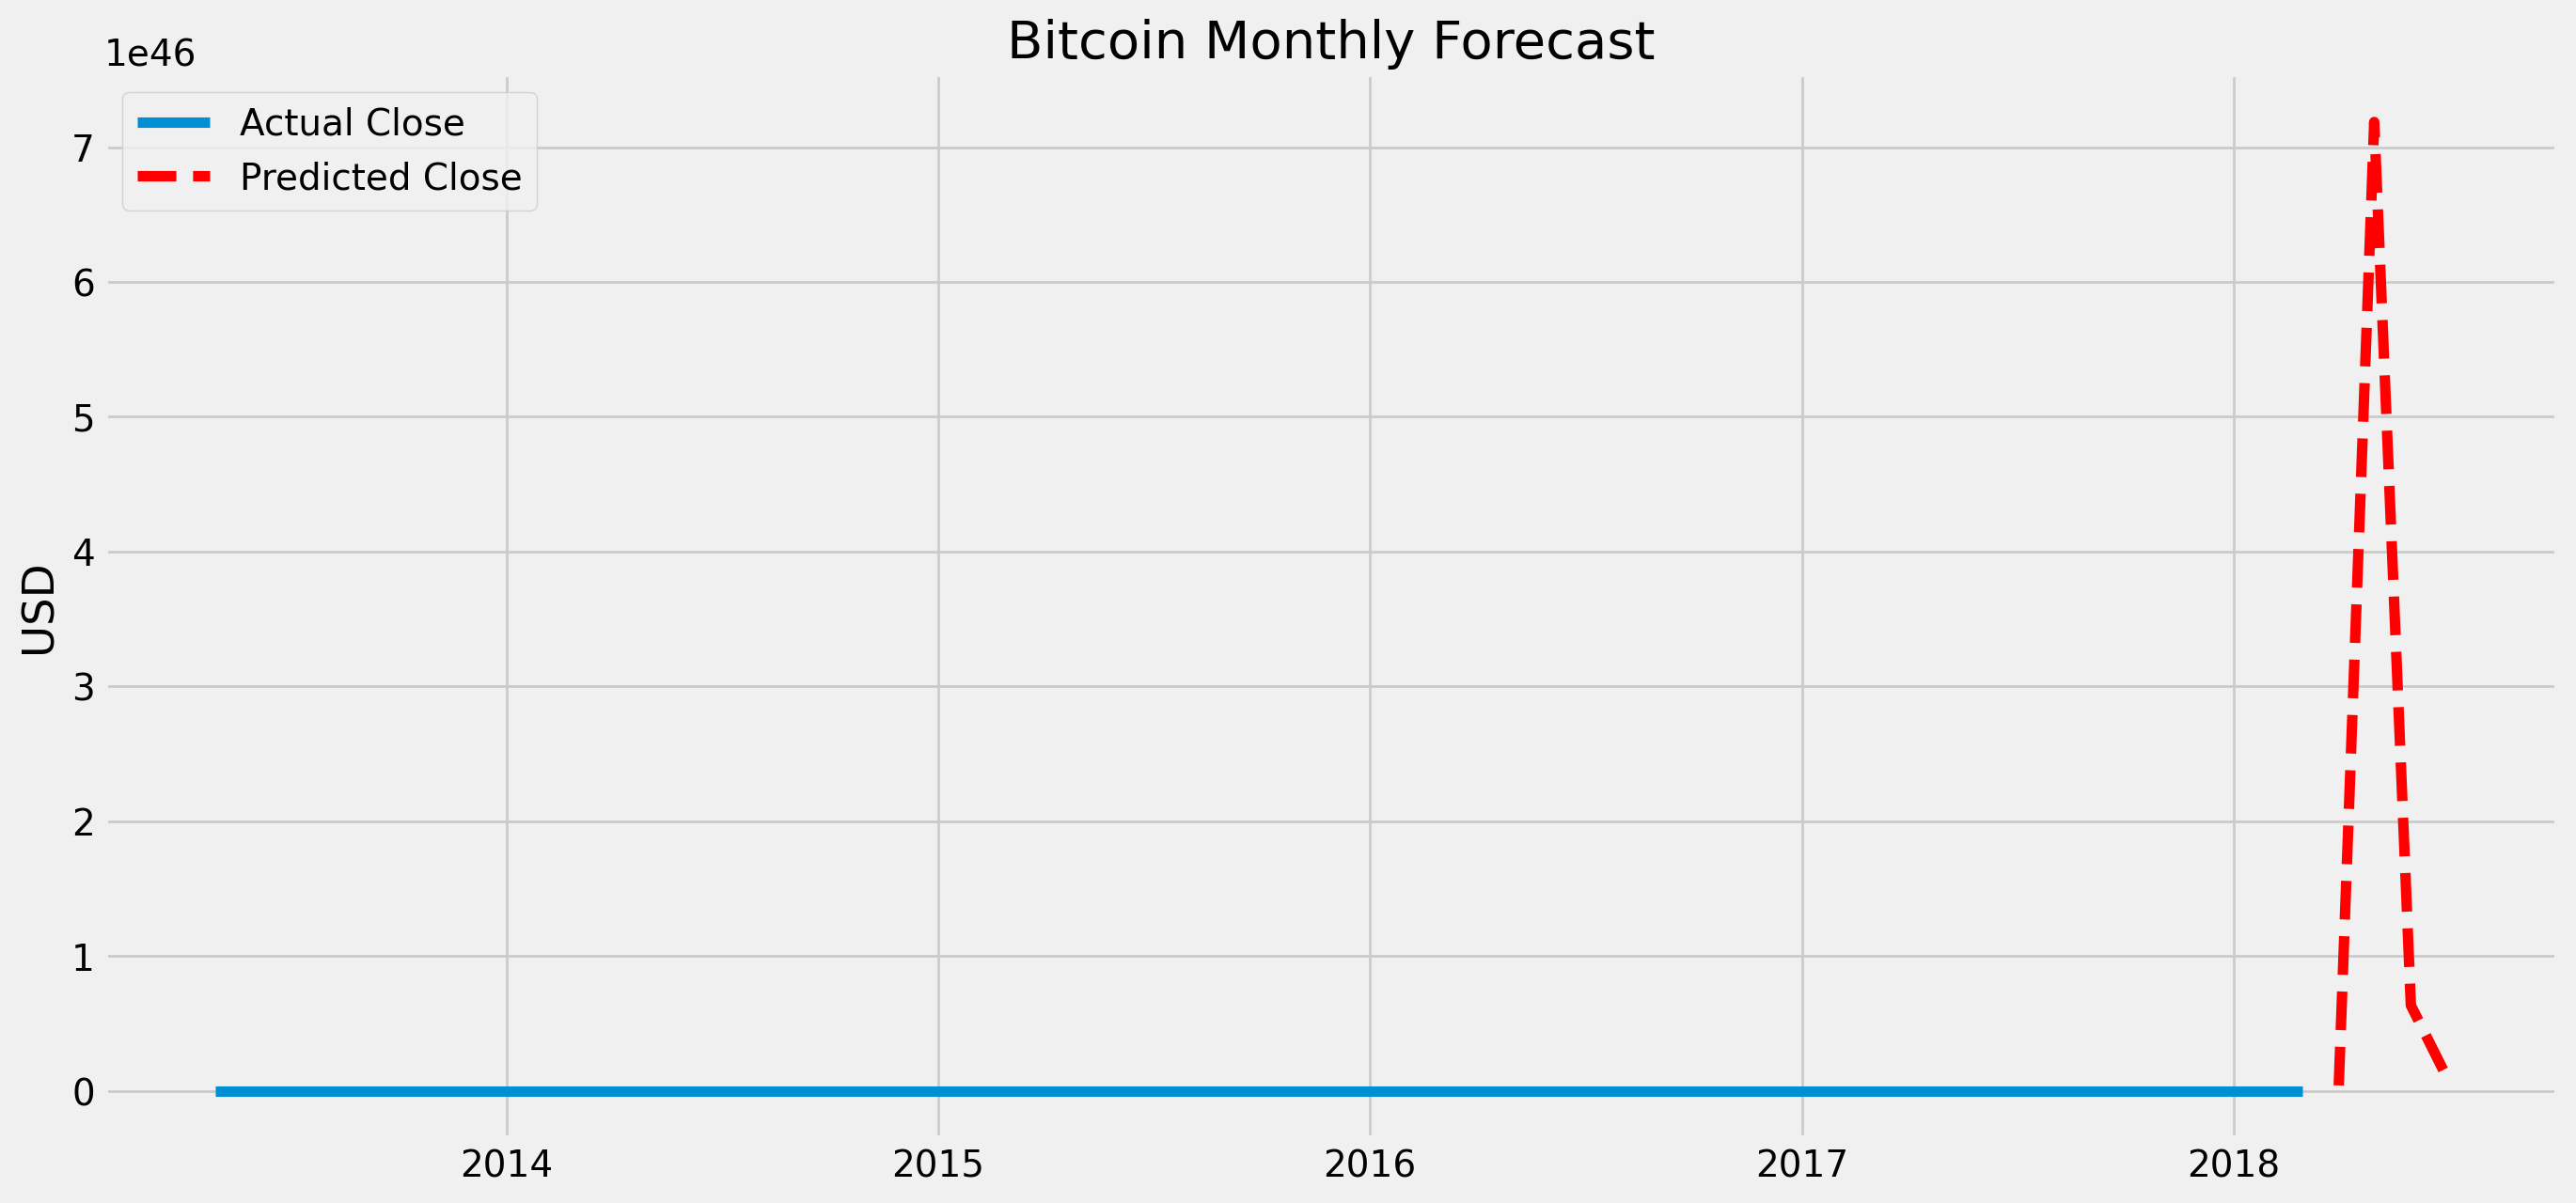

In [28]:
def inverse_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

date_list = pd.date_range(start='2018-03-31', end='2018-12-31', freq='M')

bc_mth_pred = pd.DataFrame(index=date_list, columns=['close'])

predictions = mdl_best.predict(start='2014-01-31', end='2018-06-30')

forecast = inverse_boxcox(predictions, lmbda)

bc_mth_pred['forecast'] = forecast

plt.figure(figsize=(15, 7))
plt.plot(bc_mth.index, bc_mth['close'], label='Actual Close')
plt.plot(bc_mth_pred.index, bc_mth_pred['forecast'], color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin Monthly Forecast')
plt.ylabel('USD')
plt.show()


In [29]:
import itertools
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


warnings.filterwarnings("ignore")

p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

data = pd.read_csv('/content/crypto-markets.csv')

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

best_model = None
best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit SARIMAX model
            model = SARIMAX(train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()

            # Calculate AIC score
            aic = results.aic

            # Update best model and AIC score if current model is better
            if aic < best_aic:
                best_model = results
                best_aic = aic
                best_order = param
                best_seasonal_order = param_seasonal

        except Exception as e:
            continue

# Print the best model and its parameters
print('Best SARIMAX model: SARIMA{}x{}'.format(best_order, best_seasonal_order))
print('AIC: {:.2f}'.format(best_aic))


Best SARIMAX model: SARIMANonexNone
AIC: inf


In [30]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
# SARIMAX have been tried for different seasonal periods - 12months, 6months, 4months and 3months
rslt = []
aic_best = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 6)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 3)).fit(disp=-1)
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_best:
        mdl_best = model
        aic_best = aic
        params_bst = param
    rslt.append([param, model.aic])
#printing the best suited results of the models[1]
#new dataframe to store the results of the appropriate models
rslt_table = pd.DataFrame(rslt)
#creating two columns to print values accordingly
rslt_table.columns = ['parameters', 'aic']
#sorting of values based into the relevant columns
print(rslt_table.sort_values(by = 'aic', ascending=True).head())
print(mdl_best.summary())


      parameters         aic
0   (0, 0, 0, 0)  128.511104
1   (0, 0, 0, 1)  129.337726
2   (0, 0, 1, 0)  129.444945
18  (1, 0, 0, 0)  130.248408
6   (0, 1, 0, 0)  130.286269
                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   59
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -63.256
Date:                            Thu, 08 Feb 2024   AIC                            128.511
Time:                                    12:37:27   BIC                            130.340
Sample:                                04-30-2013   HQIC                           129.196
                                     - 02-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Augmented Dickey Fuller(ADF) test result:: p = 0.000000


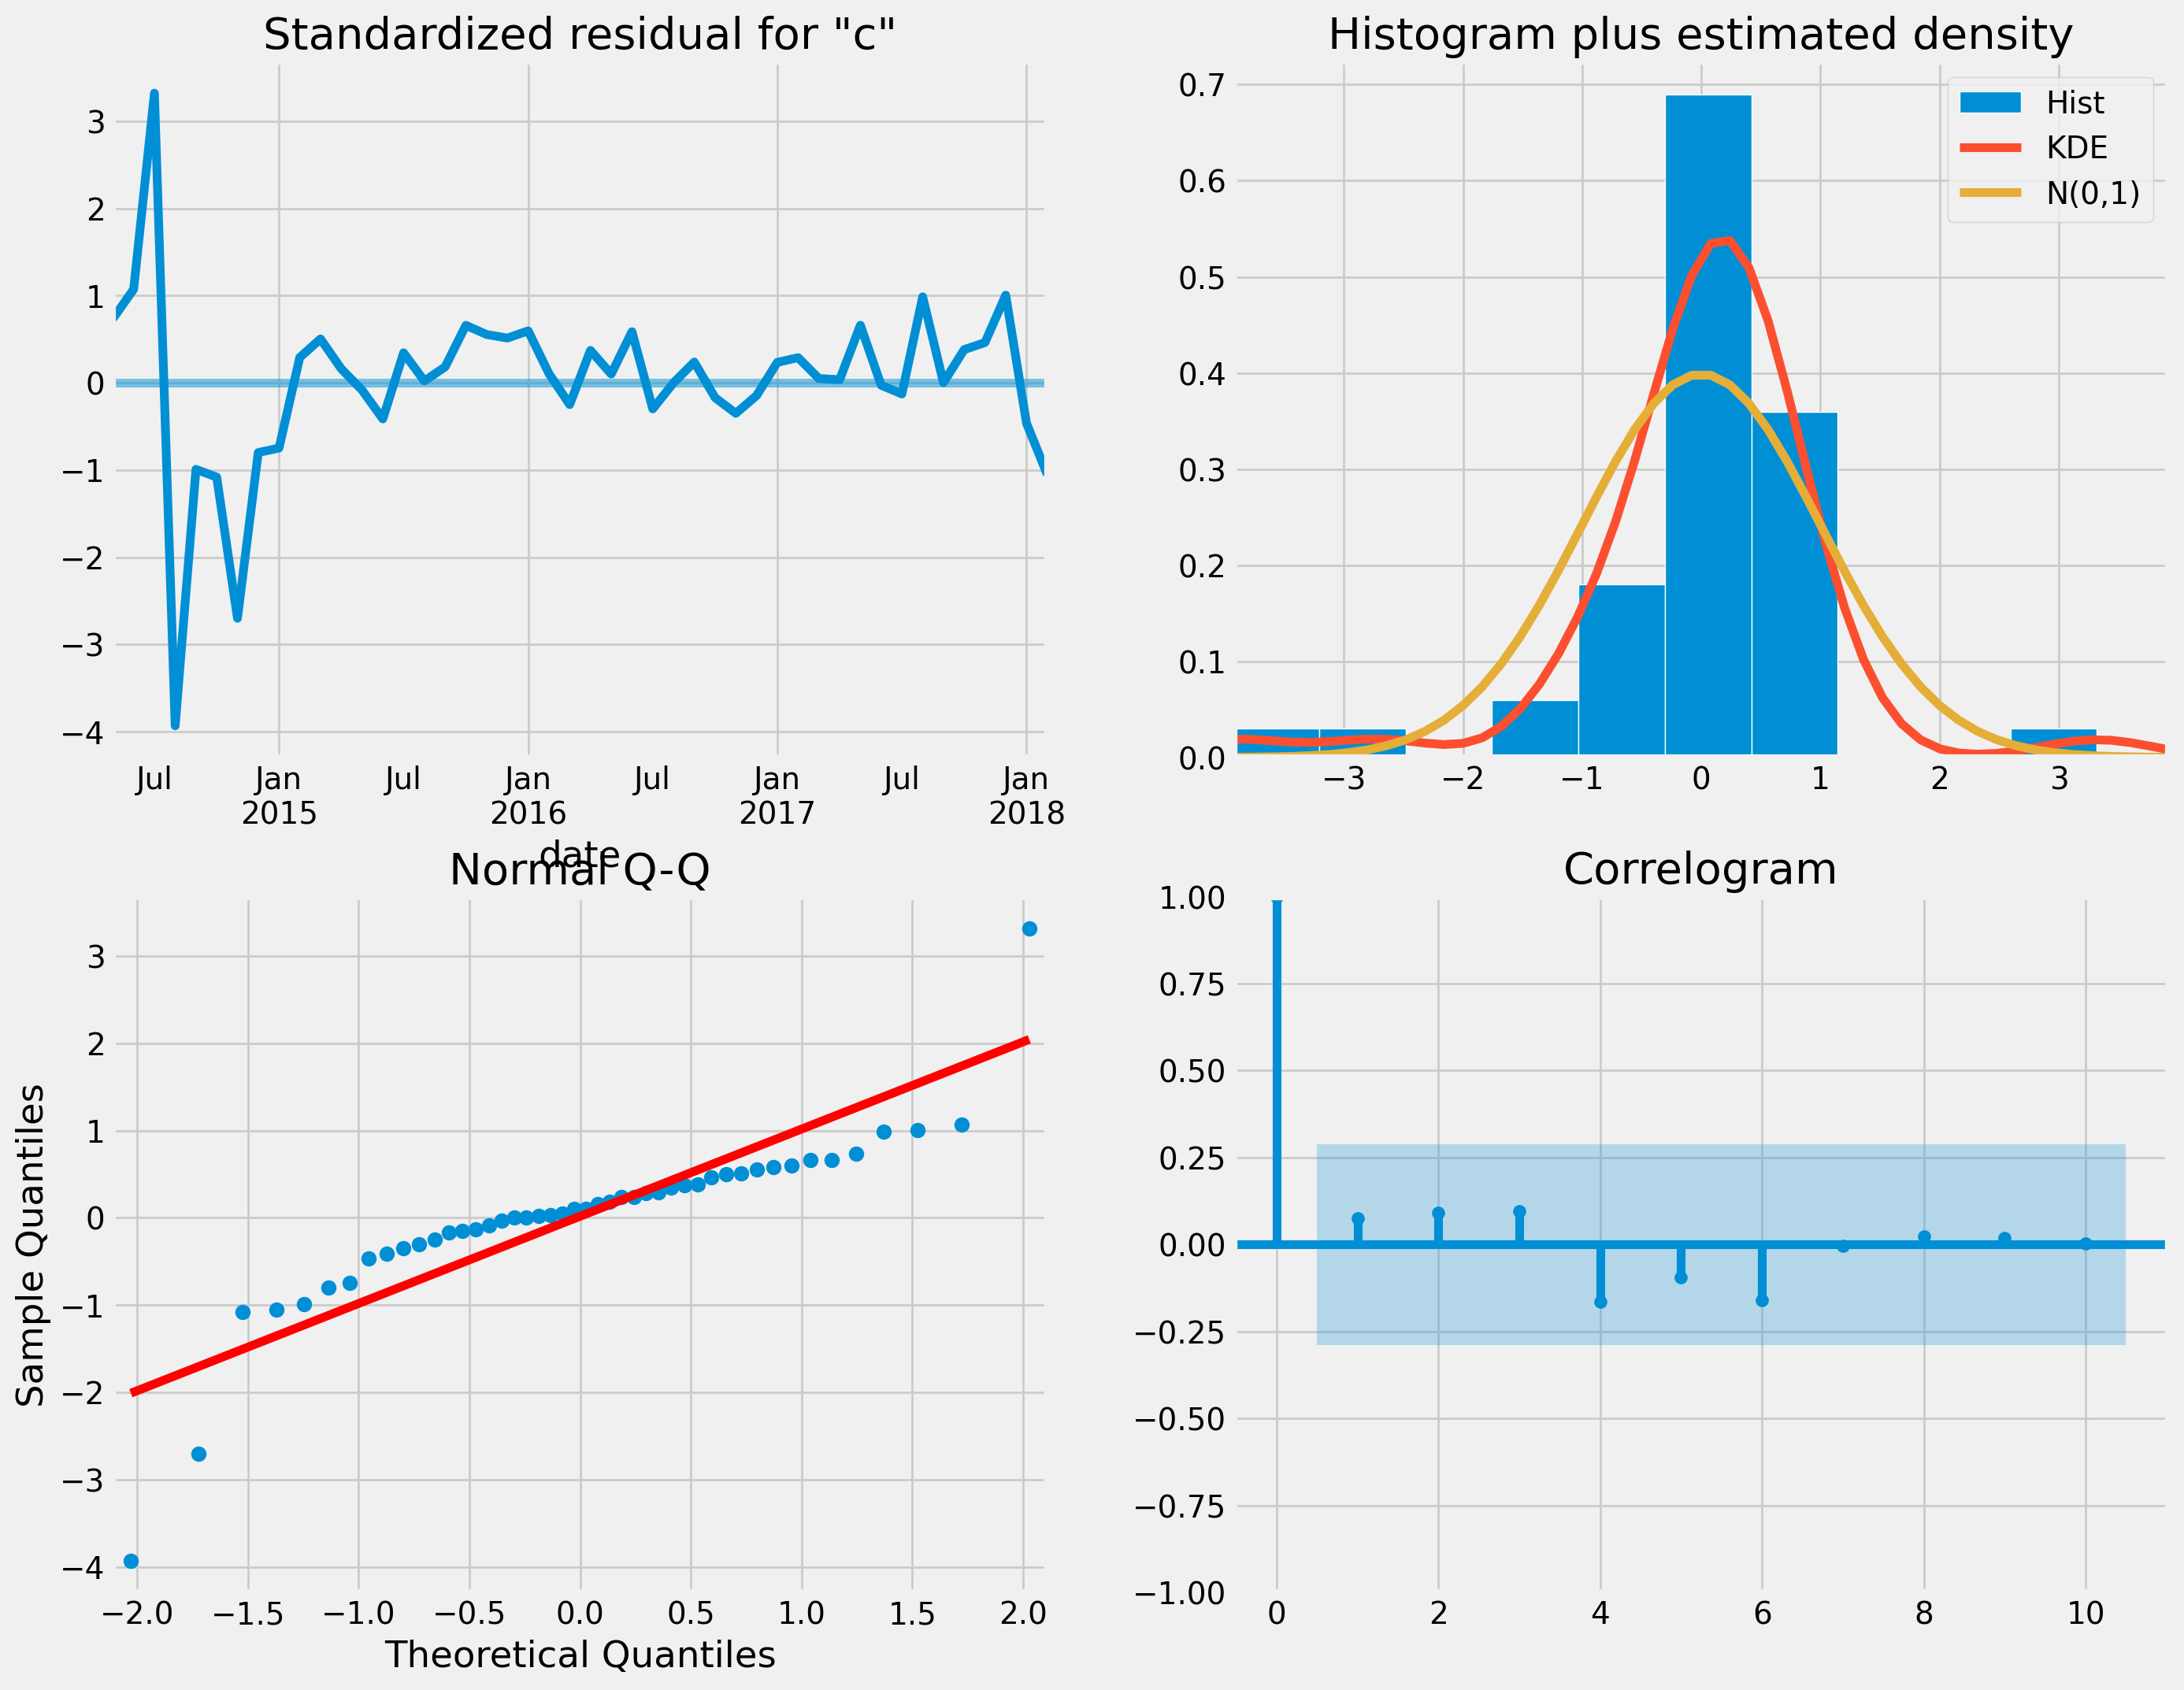

In [31]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p = %f" % adfuller(mdl_best.resid[13:])[1])
#running the model diagnostics functions and plotting its result [3]
mdl_best.plot_diagnostics(figsize=(15, 12))
plt.show()

Augmented Dickey Fuller(ADF) test result:: p=0.000000


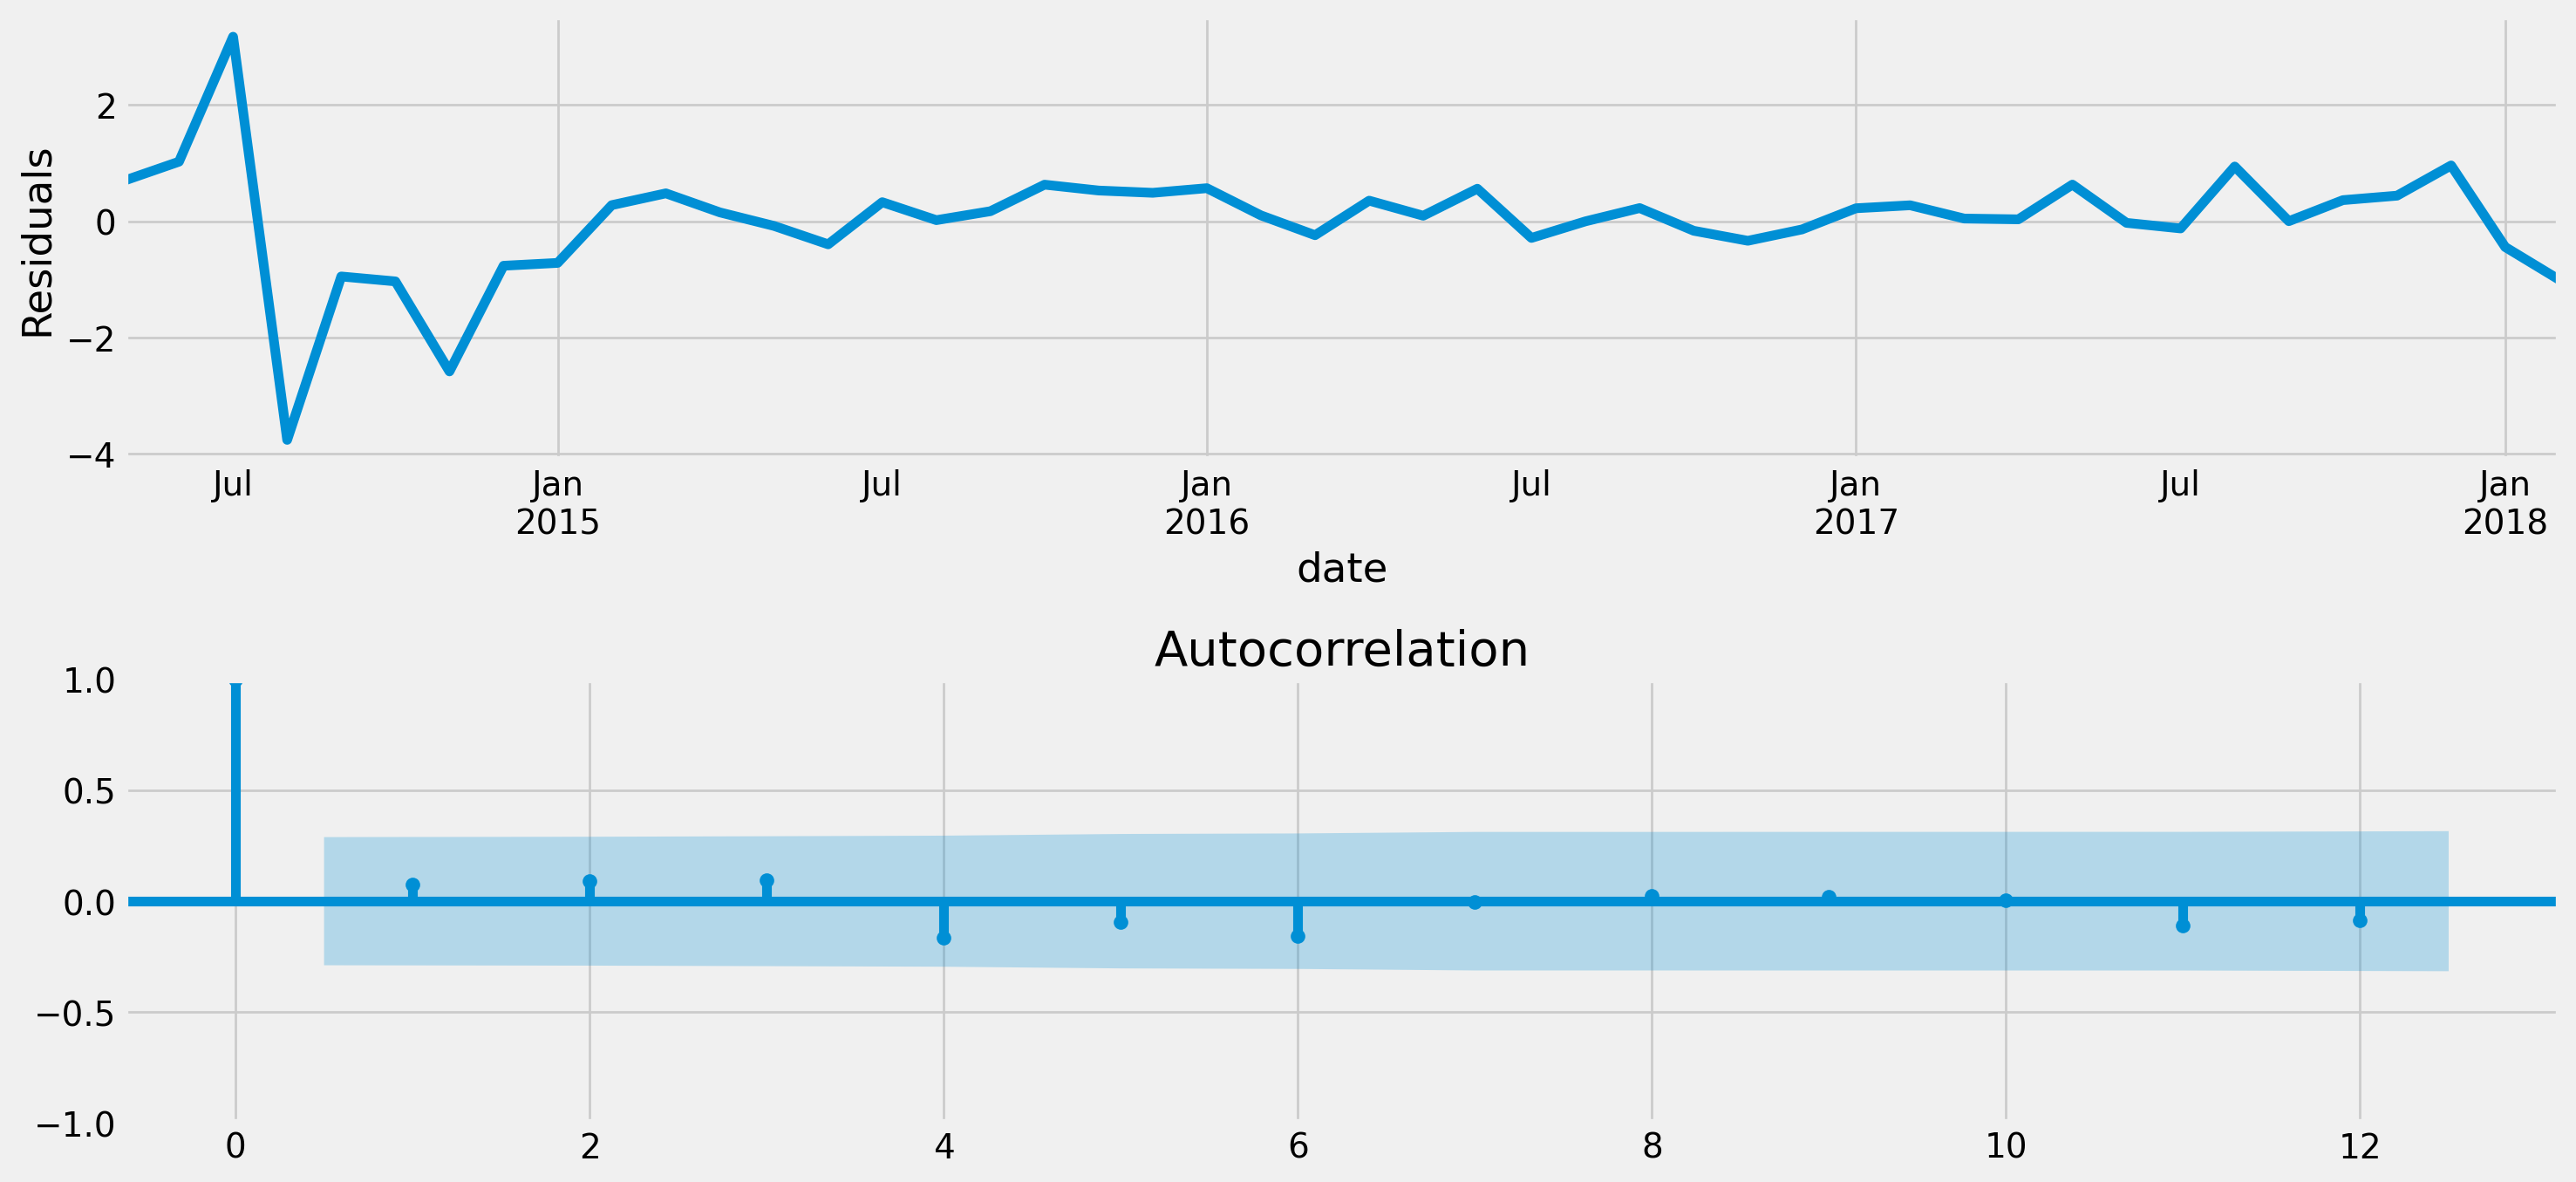

In [32]:
# Seasonal and Trend decomposition using Loess(STL) decomposition[1]
plt.figure(figsize=(15,7))
plt.subplot(211)
mdl_best.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(mdl_best.resid[13:].values.squeeze(), lags=12, ax=ax)

#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(mdl_best.resid[13:])[1])

plt.tight_layout()
plt.show()

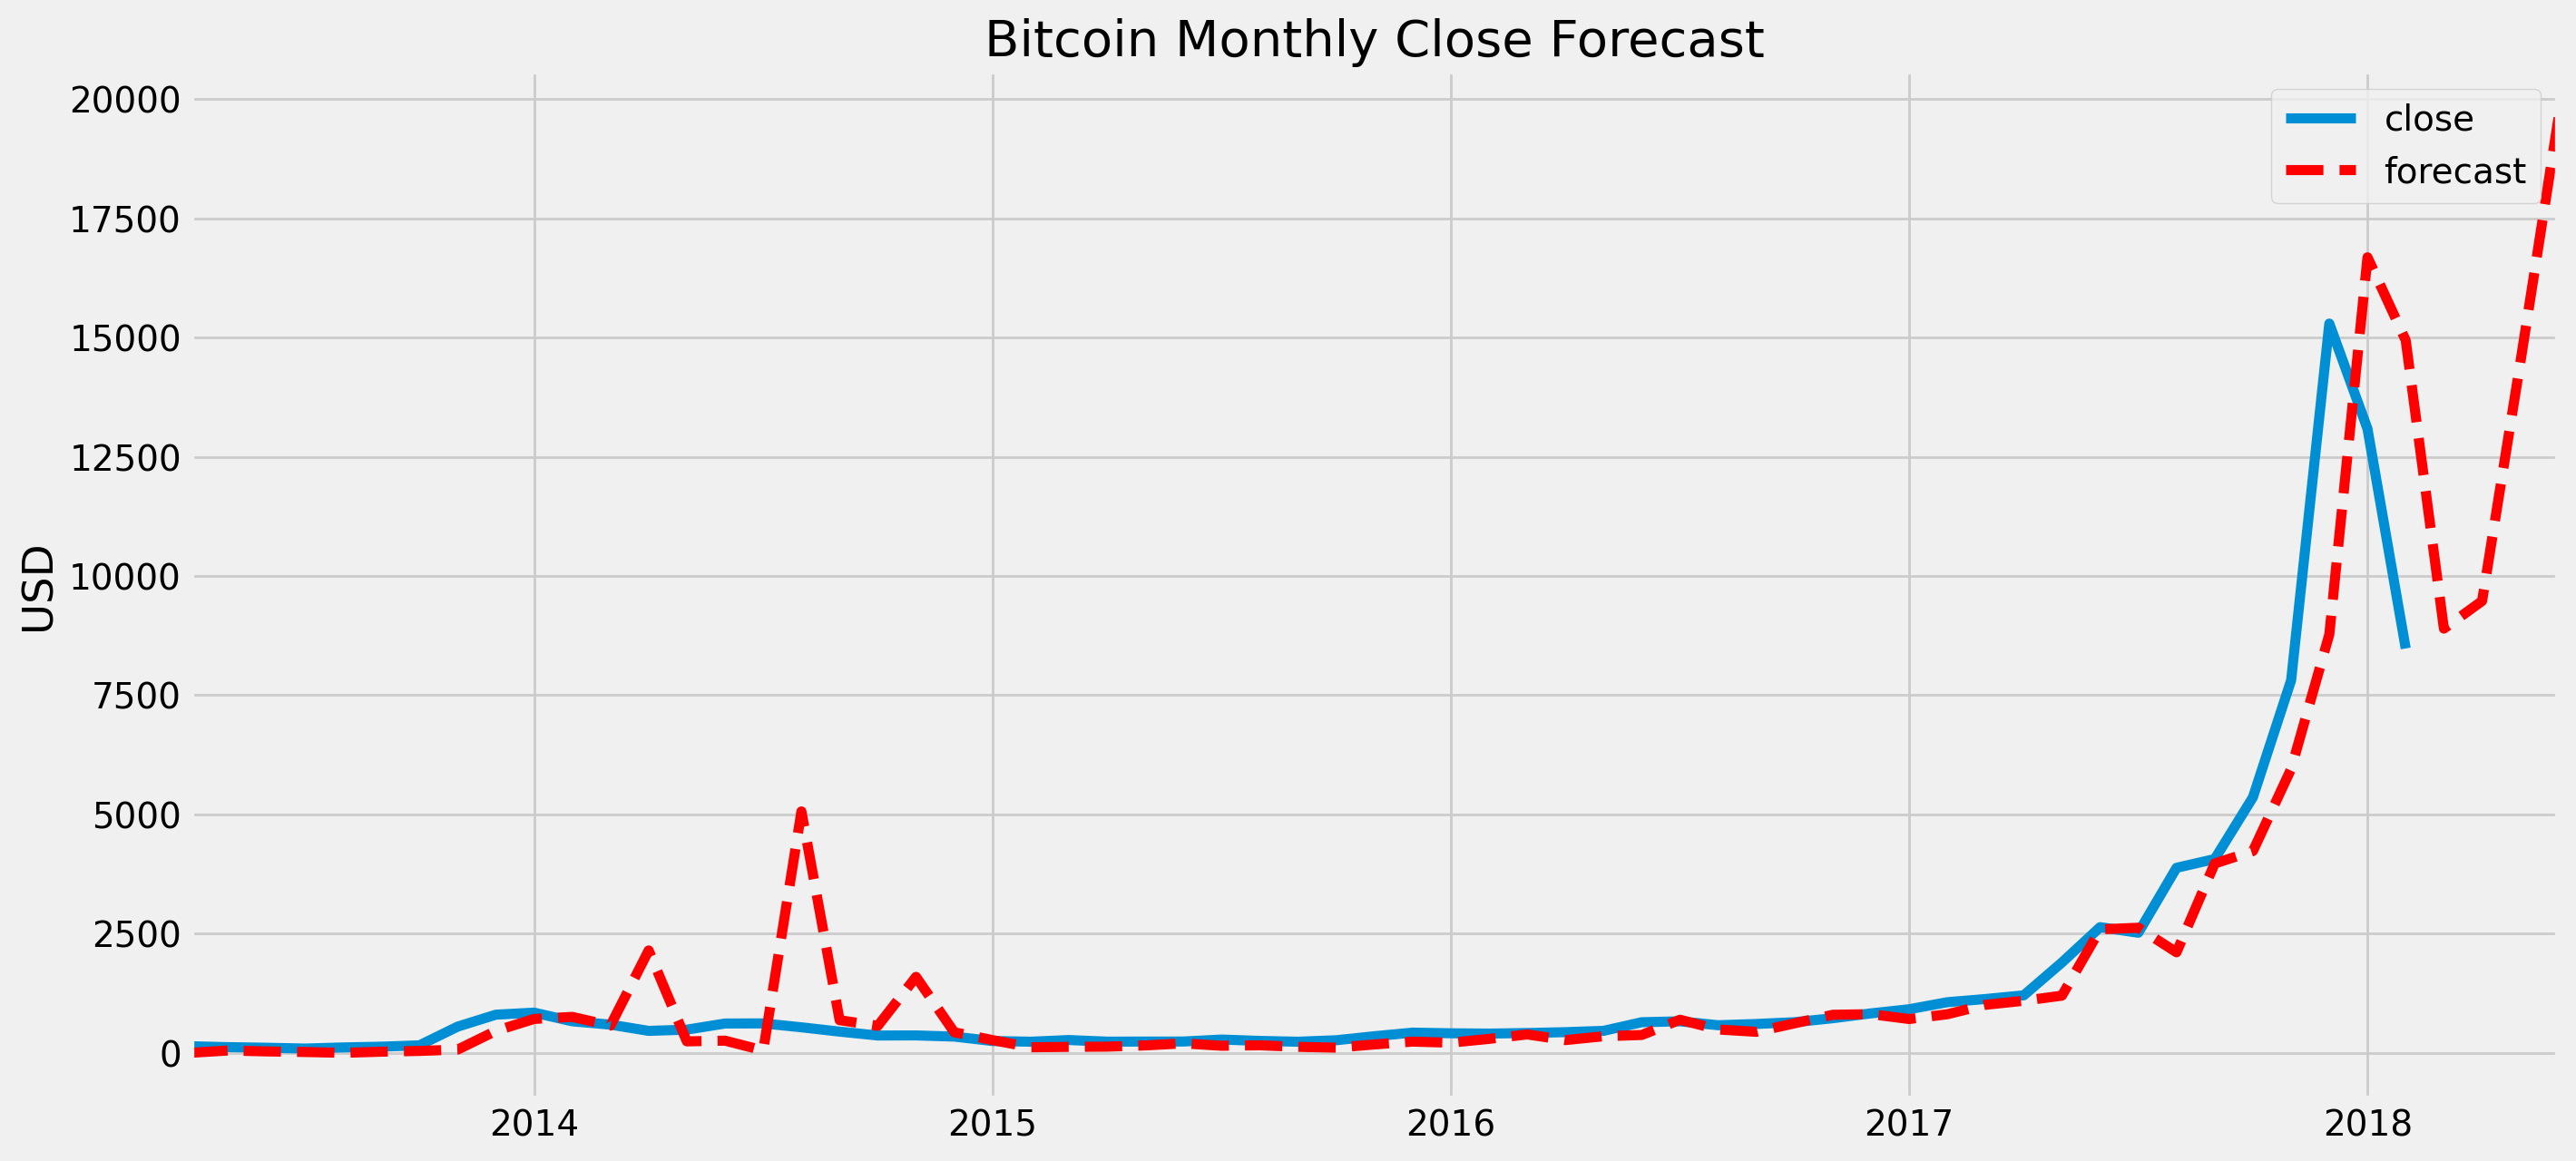

In [41]:
# Bitcoin Price Predictions
import pandas as pd
import matplotlib.pyplot as plt
bc_mth2 = bc_mth[['close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]

#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= bc_mth.columns)
bc_mth2 = pd.concat([bc_mth2, future])

#monthly forecasting of the values of Bitcoin's close prices
bc_mth2['forecast'] = invboxcox(mdl_best.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
bc_mth2.close.plot()
bc_mth2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [42]:
#storing the forecasts into new variable
y_forecastd = bc_mth2.forecast
#storing the actual close price values
y_truth = bc_mth2['2015-01-01':'2017-01-01'].close

# implementing the root mean square error
rmse = np.sqrt(((y_forecastd - y_truth)**2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 126.94
